# SVD cylinder flow

The singular value decomposition reduces high-dimensional data, including sequential data coming from a PDE or physics simulations. Simulation data typically uses high-resolution discretization of the spatial variable, resulting in $N$-dimensional snapshots, where $N \gg 1$. This poses significant challenges for predictive learning tasks. 

This cylinder flow data illustrates a case where $N = 89,351$, resulting from a spatial discretization of $449\times 199$ gridpoints in the $x$ and $y$ directions. Any predictive modeling task requires analyzing the time evolution of 89351 distinct raw features. 

These features are not independent and are highly correlated. We can exploit this fact to *reduce* the data, using the SVD to approximate each snapshot as its time-dependent basis coefficients in an optimal basis (proper orthogonal decomposition). 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# plotting routine for cylinder basis modes
def plot_modes(U,V,n_col=6, n_row=2): 
    
    r = min(U.shape)
    plt.figure(figsize=(2.26 * n_col, 1.5 * n_row))

    cmap = plt.cm.bwr
    for i in range(r):
        u = U[:,i]; v = V[:,i]
        ax = plt.subplot(n_row, n_col, 2*i + 1)
        levels = MaxNLocator(100,symmetric=True).tick_values(min(u),max(u))        
        quad = ax.pcolormesh(u.reshape((449,199)).real.T, cmap=cmap, vmin=min(u), vmax=max(u))
        plt.xticks(())
        plt.yticks(())

        ax2 = plt.subplot(n_row, n_col, 2*i + 2)
        plt.plot(v)


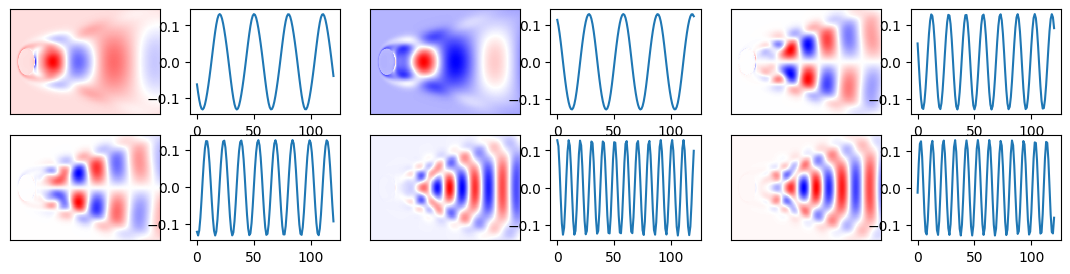

In [3]:
import numpy as np 
from scipy.io import loadmat

vortall_mat = loadmat('CYLINDER_ALL.mat')
Xall = vortall_mat['VORTALL']
N = np.max(Xall.shape)
m = 121     # observe fftpredict behavior when m=124

X = Xall[:,0:m]
[U,S,Vt] = np.linalg.svd(X,full_matrices=False)  #economy SVD
plot_modes(U[:,1:7],Vt[1:7,:].T)

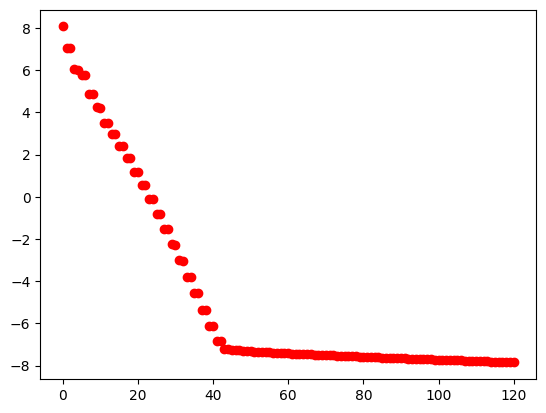

In [4]:
# energy contribution (variance captured by) each mode
plt.plot(np.log(S),'ro'); 

\begin{equation}
\begin{bmatrix}
| & | & & | \\
x_1  & x_2 &\dots & x_m \\
| & | & & | \\
| & | & & | 
\end{bmatrix}
=
\begin{bmatrix}
| &  & | \\
u_1  &\dots & u_m \\
| &  & | \\
| &  & | 
\end{bmatrix}
\begin{bmatrix}
\sigma_1 &  &  \\
  &\ddots &  \\
 &  & \sigma_r 
\end{bmatrix}
\begin{bmatrix}
| &  & | \\
v_1  &\dots & v_m \\
| &  & |
\end{bmatrix}^T
\end{equation}

With sequential flow data, each $x_i = x(t_i)$, so we can write
$$ \vec{x}(t_i) = \sigma_1 v(t_1) \vec u_1 + \sigma_2 v(t_2) \vec u_2 \dots + \sigma_r v(t_r) \vec u_r $$


In [5]:
from numpy.fft import fft

def fftpredict(v, nt):
    n = len(v)

    vhat = fft(v)
    temp = np.arange(n) 
    y = np.zeros((nt,1)) 

    # extend to any value of k using mod
    k = 0
    for i in range(nt):
      kk =  k % n
      y[i] = np.sum( vhat * np.exp(2j * np.pi * kk * temp/n)) / n
      k = k+1
    
    return y

Use the Fast Fourier Tranform to predict $a_i(t) = \sigma_iv_i(t)$ arbitrarily far in time, exploiting the fact that each $a_i(t)$ is  periodic.

/var/folders/06/b2z9x6rd4sg0ftg8c1g2b9z00000gn/T/ipykernel_6097/1233210612.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = np.sum( vhat * np.exp(2j * np.pi * kk * temp/n)) / n


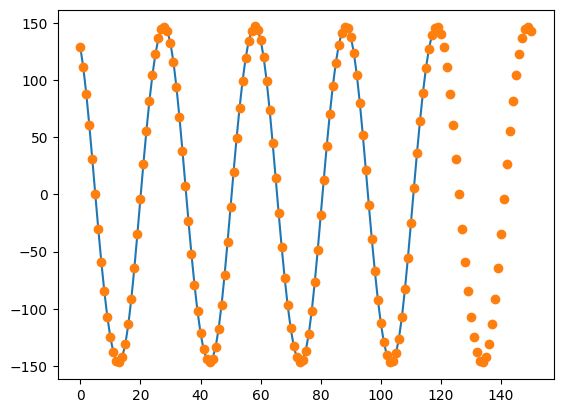

In [23]:
r = 42  # rank truncation parameter (truncated SVD approximation)
nt = 151 # predicton horizon

Atrue = U[:,0:r].T @ X
Apred = np.zeros((r,nt))

for i in range(r):
    
    v = S[i]*Vt[i,:].T    
    Apred[i,:] = fftpredict(v,nt).flatten()

plt.plot(Atrue[2,:].T)
plt.plot(Apred[2,:].T,'o')

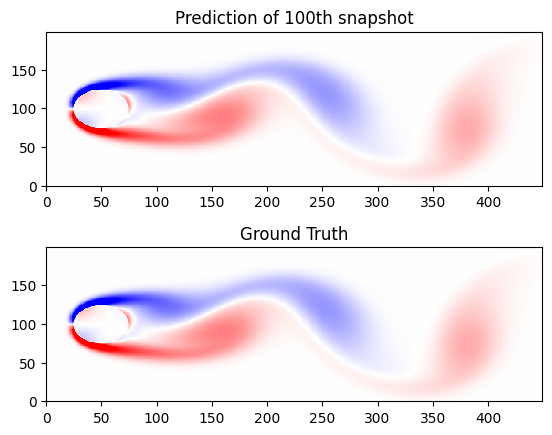

In [15]:
# Compare FFT prediction to ground truth
Xpred = U[:,0:r] @ Apred
nx = 449
ny = 199
#Plotting the 100th DMD predicted snapshot and the true snapshot
fig, (ax1,ax2) = plt.subplots(2,1)
quad_1 = ax1.pcolormesh(Xpred[:,-1].reshape((nx,ny)).T, cmap='bwr', vmin=-5, vmax=5);
ax1.set_title('Prediction of 151th snapshot');

quad_2= ax2.pcolormesh(Xall[:,-1].reshape((nx,ny)).T, cmap='bwr', vmin=-5, vmax=5);
ax2.set_title('Ground Truth')
plt.subplots_adjust( wspace=0.4, hspace=0.4);

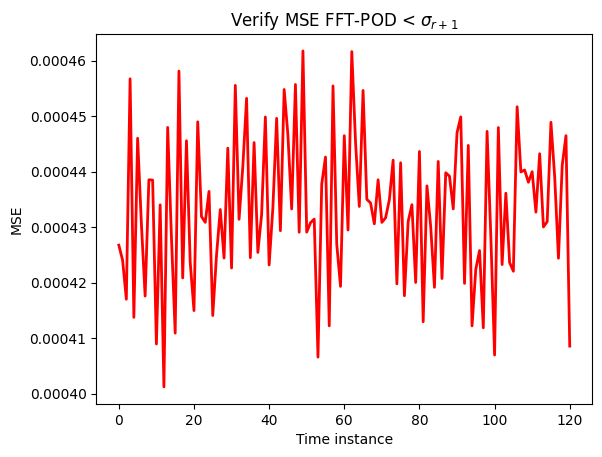

In [26]:
#Mean square error 
mse = []
for i in range(0,m):
    MSE = np.linalg.norm((Xpred[:,i] - Xall[:,i]), ord=2)
    mse.append(MSE)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mse, color='red', linewidth=2)
ax.set(title = 'Verify MSE FFT-POD < $\sigma_{r+1}$', ylabel = 'MSE', xlabel = 'Time instance');

In [ ]:
# #Comparison animation 
# %matplotlib notebook
# fig, (ax1,ax2) = plt.subplots(2,1)
# quad1 = ax1.pcolormesh(X[:,0].reshape((nx,ny)).real.T, cmap='bwr', vmin=-5, vmax=5)
# ax1.set_title('Ground Truth')

# quad2 = ax2.pcolormesh(Xhat[:,0].reshape((nx,ny)).real.T, cmap='bwr', vmin=-5, vmax=5)
# ax2.set_title('FFT Prediction')

# def init():
#     quad1.set_array(np.asarray([X]))
#     quad2.set_array(np.asarray([Xhat]))
#     ax1.set_xlim(0,nx)
#     ax1.set_ylim(0,ny)
#     ax2.set_xlim(0,nx)
#     ax2.set_ylim(0,ny)
#     return quad1, quad2,

# def animate(i):
#     quad1.set_array(X[:,i].reshape((nx,ny)).real.T.ravel())
#     quad2.set_array(Xhat[:,i].reshape((nx,ny)).real.T.ravel())
#     return quad1,quad2,

# anim = animation.FuncAnimation(fig, animate, init_func = init, frames =100, blit = False)
# plt.subplots_adjust( wspace=0.4, hspace=0.4)
# writervideo = animation.PillowWriter(fps=60)
# anim.save('comparison.gif', writer=writervideo)
# plt.show()

In [20]:
S[r+1]

0.0007323679354513978

In [21]:
1.5e-6

1.5e-06